# `Промышленное машинное обучение на Spark`
## `Задание 03: Spark Details`

<span style="color:red">Дедлайн: 5 марта 2024. 00:00</span>

<span style="color:red">Заполненный ноутбук присылать на почту <b>ekolmagorov98@yandex.ru</b> с темой письма <b>[HSE Spark 2023][Задание 03][ФИО]</b>.</span>

In [1]:
! pip install pyspark pyarrow

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import datetime

from typing import List, Optional

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 300

import pyspark
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.window import Window

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

conf = (
    SparkConf()
        .set('spark.ui.port', '4050')
        .set('spark.driver.memory', '6g')
        .setMaster('local[*]')
)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

24/02/18 11:51:40 WARN Utils: Your hostname, vm-01 resolves to a loopback address: 127.0.1.1; using 10.128.0.16 instead (on interface eth0)
24/02/18 11:51:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/18 11:51:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Скачаем и распакуем данные из соревнования [Web Traffic Time Series Forecasting](https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/leaderboard).


In [6]:
import json
import requests
import subprocess
import zipfile

folder_url = 'https://disk.yandex.ru/d/v2DatluRGmU2Ng'
file_url = '/web_traffic_data_v2.csv.zip'
# запрос ссылки на скачивание
response = requests.get('https://cloud-api.yandex.net/v1/disk/public/resources/download',
                 params={'public_key': folder_url, 'path': file_url}) 
# 'парсинг' ссылки на скачивание
data_link = response.json()['href'] 	

filename = 'web_traffic_data.csv.zip'
# путь куда распакуются данные
path = "./web_traffic_data.csv"

# запускаем скачивание вызовом команды wget из python
subprocess.run(
    ['wget', '-O', filename, data_link], # команда для исполнения
    stdout=subprocess.DEVNULL, # убираем печать отладочной информации
    stderr=subprocess.STDOUT
)

CompletedProcess(args=['wget', '-O', 'web_traffic_data.csv.zip', 'https://downloader.disk.yandex.ru/disk/5fb8135581c076119c5f003ceb0ac472134f7c6a243ee310bd702e5fc984fcac/65d22837/qo_oUU0UNiEpD-z6-zCIgT_3WffF4HNqJJJq_FMtn5WaEY0cM_1uUCfDatV7tgv7rdx08p1BkaBAc6gEcYOliQ%3D%3D?uid=0&filename=web_traffic_data_v2.csv.zip&disposition=attachment&hash=E49MtubvUrb12FBU2QEZgwKTWY0nBRgBDJOGkLQys5mIjn242W1EcdqTcysdGxI5q/J6bpmRyOJonT3VoXnDag%3D%3D%3A/web_traffic_data_v2.csv.zip&limit=0&content_type=application%2Fzip&owner_uid=1199758960&fsize=37763121&hid=87218715b9182af504ddba78af588dcf&media_type=compressed&tknv=v2'], returncode=0)

Произведём распаковку таблицы

In [7]:
! unzip web_traffic_data.csv.zip 

# тк все данные уже распакованы, то удалим ненужные далее архивы с данными
! rm -rf web_traffic_data.csv.zip

Archive:  web_traffic_data.csv.zip
  inflating: web_traffic_data_v2.csv  


Загрузим информацию о просмотрах страниц Википедии по дням в виде DataFrame:

In [12]:
# Сконструируем схему DataFrame в явном виде
# Это необходимо для более простого заполнения пропусков
#   так по умолчанию все колонки с пропусками определяются
#   как строковые
schema = T.StructType()
schema.add('Page', T.StringType())

delta = datetime.timedelta(days=1)
date = datetime.date.fromisoformat('2015-07-01')
for _ in range(803):
    schema.add(date.isoformat(), T.FloatType())
    date += delta

df = (
    spark.read.format('csv')
        .option('header', True)
        .option('sep', ',')
        .schema(schema)
        .load('./web_traffic_data_v2.csv')
        .fillna(0.0)
)

df.limit(5).toPandas()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,Idioma_español_es.wikipedia.org_all-access_spider,99.0,116.0,70.0,63.0,59.0,79.0,54.0,83.0,72.0,...,227.0,304.0,93.0,255.0,101.0,255.0,567.0,106.0,129.0,52.0
1,張藝興_zh.wikipedia.org_mobile-web_all-agents,306.0,305.0,261.0,466.0,441.0,343.0,390.0,299.0,292.0,...,529.0,756.0,758.0,691.0,821.0,631.0,643.0,591.0,784.0,1035.0
2,Special:WhatLinksHere_commons.wikimedia.org_al...,21.0,33.0,42.0,37.0,36.0,70.0,42.0,31.0,24.0,...,22.0,769.0,458.0,101.0,44.0,542.0,817.0,44.0,792.0,165.0
3,The_Hardkiss_ru.wikipedia.org_all-access_spider,10.0,1.0,2.0,3.0,7.0,4.0,3.0,5.0,3.0,...,3.0,10.0,3.0,2.0,6.0,5.0,5.0,3.0,7.0,4.0
4,金世正_zh.wikipedia.org_all-access_spider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,19.0,26.0,13.0,7.0,19.0,14.0,15.0,12.0,3.0


***Замечание:*** Используйте метод `cache` для сохранения промежуточных результатов, которые Вы планируете переиспользовать!

**Задание 01:** Разбейте колонку `Page` в соответствии со схемой в описании данных (`name_project_access_agent`). В результате нужно составить DataFrame из $5$ колонок: `Page`, `Name`, `Project`, `Access`, `Agent`.

*Замечание 0*: Не используйте UDF.

*Замечание 1*: Название страницы (`Name`) может содержать любое количество символов `_`.

*Замечание 2*: Некоторые строки "обёрнуты" в двойные кавычки. Желательно первой трансформацией над колонкой `Page` из всех таких строк убрать лишние внешние кавычки.

*Замечание 3:* Строки, которые не удовлетворяют указанному паттерну, нужно выделить в отдельный DataFrame.

*Замечание 4:* Для удобства, используйте возможность сохранения колоночных выражений в переменные.

*Подсказка 1:* Подстроки переменной длины можно выделять [следующим образом](https://stackoverflow.com/questions/53153149/remove-last-few-characters-in-pyspark-dataframe-column).

*Подсказка 2:* Данную задачу можно решать разными вариантами кода, функции которые могут быть полезны для неё: `.when().otherwise()`, `substring`, `size`, `expr`, `split`, `array_join`, `slice`, `element_at`.

Посмотрим какие строки обёрнуты в двойные кавычки

In [14]:
# YOUR CODE HERE

+-----------------------------------------------------------------------------------------------------------------------------------------+
|Page                                                                                                                                     |
+-----------------------------------------------------------------------------------------------------------------------------------------+
|"File:It's_said_that_Colby's_Pincher_was_""The_greatest_fighting_dog_that_ever_lived"".jpg_commons.wikimedia.org_mobile-web_all-agents"  |
|"File:Bundesarchiv_Bild_101I-022-2948-19,_Russland,_Unternehmen_""Zitadelle""._Soldatengrab.jpg_commons.wikimedia.org_desktop_all-agents"|
|"""Heroes""_(David_Bowie_album)_en.wikipedia.org_desktop_all-agents"                                                                     |
|"Eddie_""The_Eagle""_Edwards_en.wikipedia.org_desktop_all-agents"                                                                        |
|"Evita_Muñoz_""Chac

Теперь попробуем убрать внешние двойные кавычки

In [15]:
# YOUR CODE HERE

df.filter(F.col("Page").contains("\"")).select("Page").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------+
|Page                                                                                                                                   |
+---------------------------------------------------------------------------------------------------------------------------------------+
|"""Awaken                                                                                                                              |
|File:It's_said_that_Colby's_Pincher_was_""The_greatest_fighting_dog_that_ever_lived"".jpg_commons.wikimedia.org_mobile-web_all-agents  |
|File:Bundesarchiv_Bild_101I-022-2948-19,_Russland,_Unternehmen_""Zitadelle""._Soldatengrab.jpg_commons.wikimedia.org_desktop_all-agents|
|""Heroes""_(David_Bowie_album)_en.wikipedia.org_desktop_all-agents                                                                     |
|Eddie_""The_Eagle""_Edwards_en.wi

Теперь разобьём колонку Page.

In [21]:
### YOUR CODE HERE:


articles = ...
corrupted_articles = ...

articles.limit(5).toPandas()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,Project,Access,Agent
0,Idioma_español_es.wikipedia.org_all-access_spider,99.0,116.0,70.0,63.0,59.0,79.0,54.0,83.0,72.0,...,255.0,101.0,255.0,567.0,106.0,129.0,52.0,es.wikipedia.org,all-access,spider
1,張藝興_zh.wikipedia.org_mobile-web_all-agents,306.0,305.0,261.0,466.0,441.0,343.0,390.0,299.0,292.0,...,691.0,821.0,631.0,643.0,591.0,784.0,1035.0,zh.wikipedia.org,mobile-web,all-agents
2,Special:WhatLinksHere_commons.wikimedia.org_al...,21.0,33.0,42.0,37.0,36.0,70.0,42.0,31.0,24.0,...,101.0,44.0,542.0,817.0,44.0,792.0,165.0,commons.wikimedia.org,all-access,spider
3,The_Hardkiss_ru.wikipedia.org_all-access_spider,10.0,1.0,2.0,3.0,7.0,4.0,3.0,5.0,3.0,...,2.0,6.0,5.0,5.0,3.0,7.0,4.0,ru.wikipedia.org,all-access,spider
4,金世正_zh.wikipedia.org_all-access_spider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,7.0,19.0,14.0,15.0,12.0,3.0,zh.wikipedia.org,all-access,spider


Проверьте, что предобработка выполнена верно:

In [17]:
corrupted_articles.select("Page").show(truncate=False)

+---------+
|Page     |
+---------+
|"""Awaken|
+---------+



In [18]:
articles.groupBy('Project').count().show(truncate=False)
articles.groupBy('Access').count().show(truncate=False)
articles.groupBy('Agent').count().show(truncate=False)

+---------------------+-----+
|Project              |count|
+---------------------+-----+
|commons.wikimedia.org|2255 |
|en.wikipedia.org     |5071 |
|www.mediawiki.org    |1525 |
|de.wikipedia.org     |3734 |
|es.wikipedia.org     |2848 |
|ja.wikipedia.org     |4236 |
|ru.wikipedia.org     |3131 |
|zh.wikipedia.org     |3573 |
|fr.wikipedia.org     |3626 |
+---------------------+-----+

+----------+-----+
|Access    |count|
+----------+-----+
|desktop   |7231 |
|all-access|15317|
|mobile-web|7451 |
+----------+-----+

+----------+-----+
|Agent     |count|
+----------+-----+
|all-agents|22744|
|spider    |7255 |
+----------+-----+



**Задание 02:** Выполните unpivot исходных данных.

*Замечание 1*: Выражение для unpivot нужно сконструировать циклом по всем колонкам с датами.

*Замечание 2*: В колоночных строковых выражениях можно указывать колонки с произвольным названием при использовании экранирования. Например: ``` `2015-07-01` ```. Так как иначе формат даты ```2015-07-01``` будет интерпретироваться как математическое выражение.  

In [19]:
# YOUR CODE HERE

+--------------------+----------+-----+
|                Page|       Day|Views|
+--------------------+----------+-----+
|Idioma_español_es...|2015-07-01| 99.0|
|Idioma_español_es...|2015-07-02|116.0|
|Idioma_español_es...|2015-07-03| 70.0|
|Idioma_español_es...|2015-07-04| 63.0|
|Idioma_español_es...|2015-07-05| 59.0|
|Idioma_español_es...|2015-07-06| 79.0|
|Idioma_español_es...|2015-07-07| 54.0|
|Idioma_español_es...|2015-07-08| 83.0|
|Idioma_español_es...|2015-07-09| 72.0|
|Idioma_español_es...|2015-07-10| 77.0|
+--------------------+----------+-----+
only showing top 10 rows



**Задание 03:** Для каждой записи в данных посчитайте среднее число просмотров за предыдущие $14$ дней.

*Замечание 1*: Используйте оконные функции.

*Замечание 2*: Для работы с датами можно использовать функцию `cast` для преобразования строки в timestamp.

*Замечание 3*: Проанализируйте [ответы `ZygD` и `zero323`](https://stackoverflow.com/questions/33207164/spark-window-functions-rangebetween-dates).

In [22]:
### YOUR CODE HERE:


+-------------------------------------------------+----------+-----+-----------------+
|Page                                             |Day       |Views|Mean Views       |
+-------------------------------------------------+----------+-----+-----------------+
|Idioma_español_es.wikipedia.org_all-access_spider|2015-07-01|99.0 |99.0             |
|Idioma_español_es.wikipedia.org_all-access_spider|2015-07-02|116.0|107.5            |
|Idioma_español_es.wikipedia.org_all-access_spider|2015-07-03|70.0 |95.0             |
|Idioma_español_es.wikipedia.org_all-access_spider|2015-07-04|63.0 |87.0             |
|Idioma_español_es.wikipedia.org_all-access_spider|2015-07-05|59.0 |81.4             |
|Idioma_español_es.wikipedia.org_all-access_spider|2015-07-06|79.0 |81.0             |
|Idioma_español_es.wikipedia.org_all-access_spider|2015-07-07|54.0 |77.14285714285714|
|Idioma_español_es.wikipedia.org_all-access_spider|2015-07-08|83.0 |77.875           |
|Idioma_español_es.wikipedia.org_all-access

**Задание 04:** По исходным данным посчитайте суммарное число просмотров за все дни. Отсортируйте страницы по убыванию числа просмотров.
    
*Замечание*: Используйте RDD API.

In [23]:
### YOUR CODE HERE:

In [24]:
most_viewed = views.take(10)
most_viewed

[('Main_Page_en.wikipedia.org_mobile-web_all-agents', 3838848757.0),
 ('Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents', 2267327557.0),
 ('Wikipedia:Portada_es.wikipedia.org_all-access_all-agents', 958693538.0),
 ('Spezial:Suche_de.wikipedia.org_desktop_all-agents', 305565356.0),
 ('Special:Book_en.wikipedia.org_desktop_all-agents', 216175504.0),
 ('Sp?cial:Search_fr.wikipedia.org_desktop_all-agents', 130453754.0),
 ('XHamster_en.wikipedia.org_mobile-web_all-agents', 121623395.0),
 ('Special:CreateAccount_commons.wikimedia.org_desktop_all-agents',
  109114961.0),
 ('Especial:Buscar_es.wikipedia.org_mobile-web_all-agents', 99640828.0),
 ('Special:搜索_zh.wikipedia.org_desktop_all-agents', 66987851.0)]

**Задание 05:** Возьмите страницу с самым большим числом просмотром. Изобразите на одном графике динамику просмотров и средних просмотров за $14$ дней по дням.

In [25]:
most_viewed_page_name = most_viewed[0][0]
most_viewed_page_name

'Main_Page_en.wikipedia.org_mobile-web_all-agents'

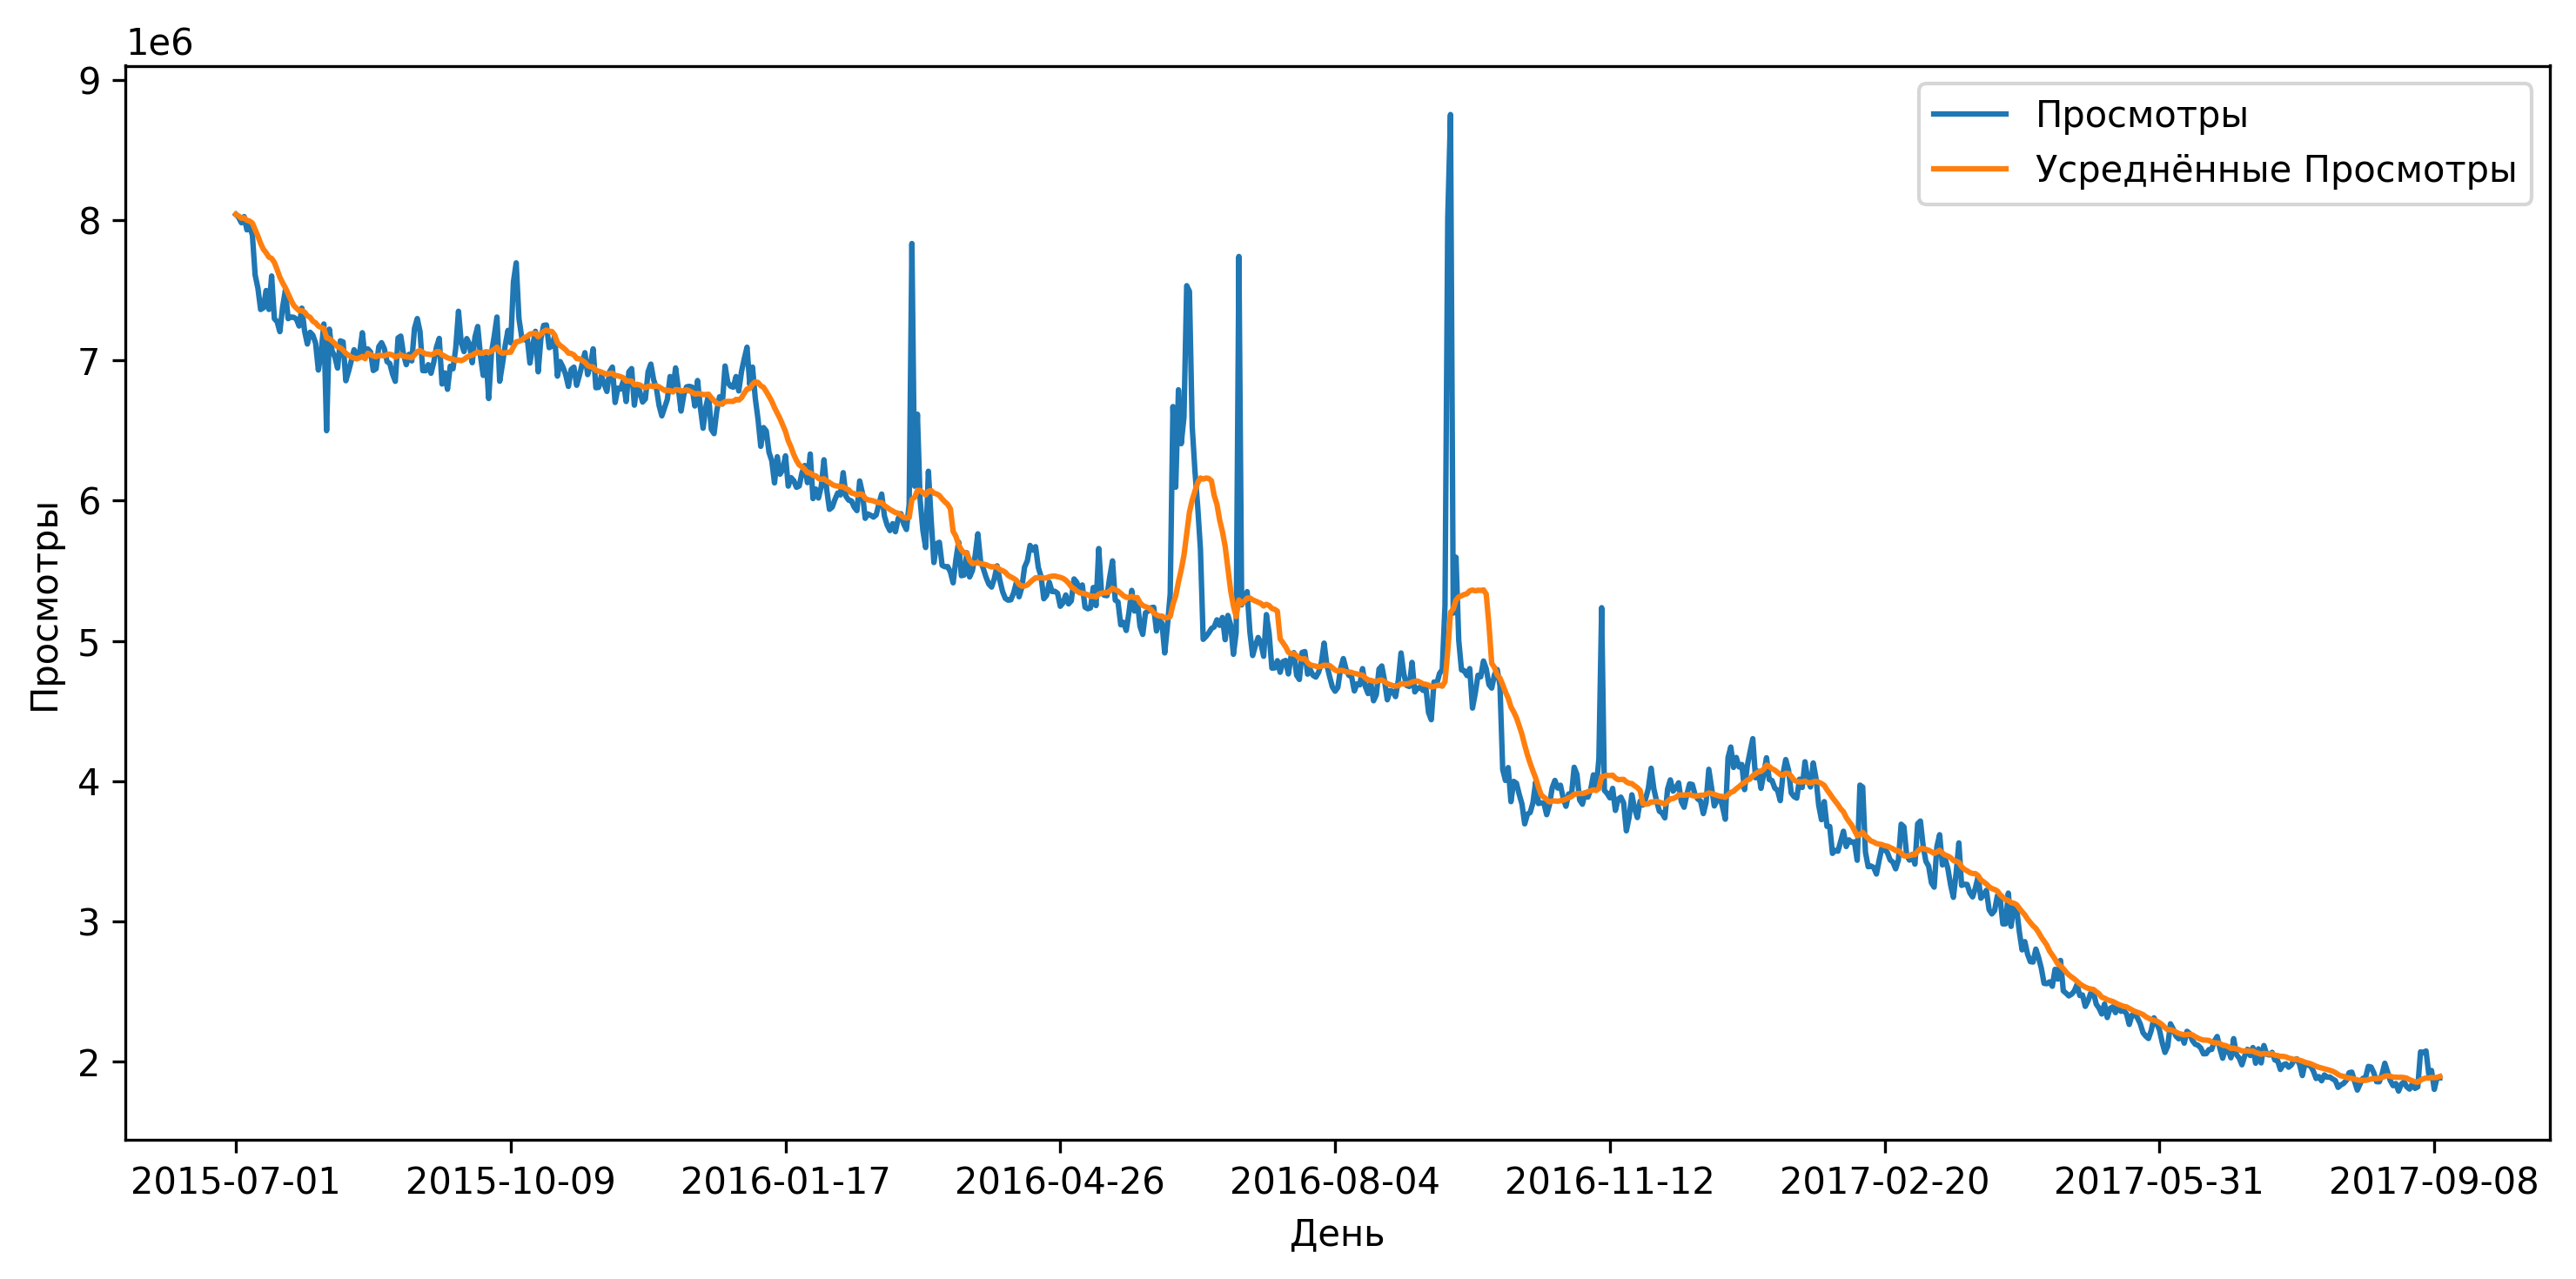

In [27]:
# YOUR CODE HERE

**Задание 06:** Используя информацию из DataFrame `articles`, посчитайте для каждой записи в разрезе Project/Access максимальное число просмотров за все предшествующие дни.

In [28]:
### YOUR CODE HERE:


+-----------------+-------+----------+------+---------+
|Project          |Access |Day       |Views |Max Views|
+-----------------+-------+----------+------+---------+
|www.mediawiki.org|desktop|2015-07-01|5243.0|5243.0   |
|www.mediawiki.org|desktop|2015-07-02|5130.0|5243.0   |
|www.mediawiki.org|desktop|2015-07-03|4865.0|5243.0   |
|www.mediawiki.org|desktop|2015-07-04|4438.0|5243.0   |
|www.mediawiki.org|desktop|2015-07-05|4832.0|5243.0   |
|www.mediawiki.org|desktop|2015-07-06|5090.0|5243.0   |
|www.mediawiki.org|desktop|2015-07-07|5116.0|5243.0   |
|www.mediawiki.org|desktop|2015-07-08|5215.0|5243.0   |
|www.mediawiki.org|desktop|2015-07-09|5219.0|5243.0   |
|www.mediawiki.org|desktop|2015-07-10|5246.0|5246.0   |
+-----------------+-------+----------+------+---------+
only showing top 10 rows



**Задание 07:** Изобразите динамику максимального числа просмотров за предшествующие дни в разрезе Project/Access.

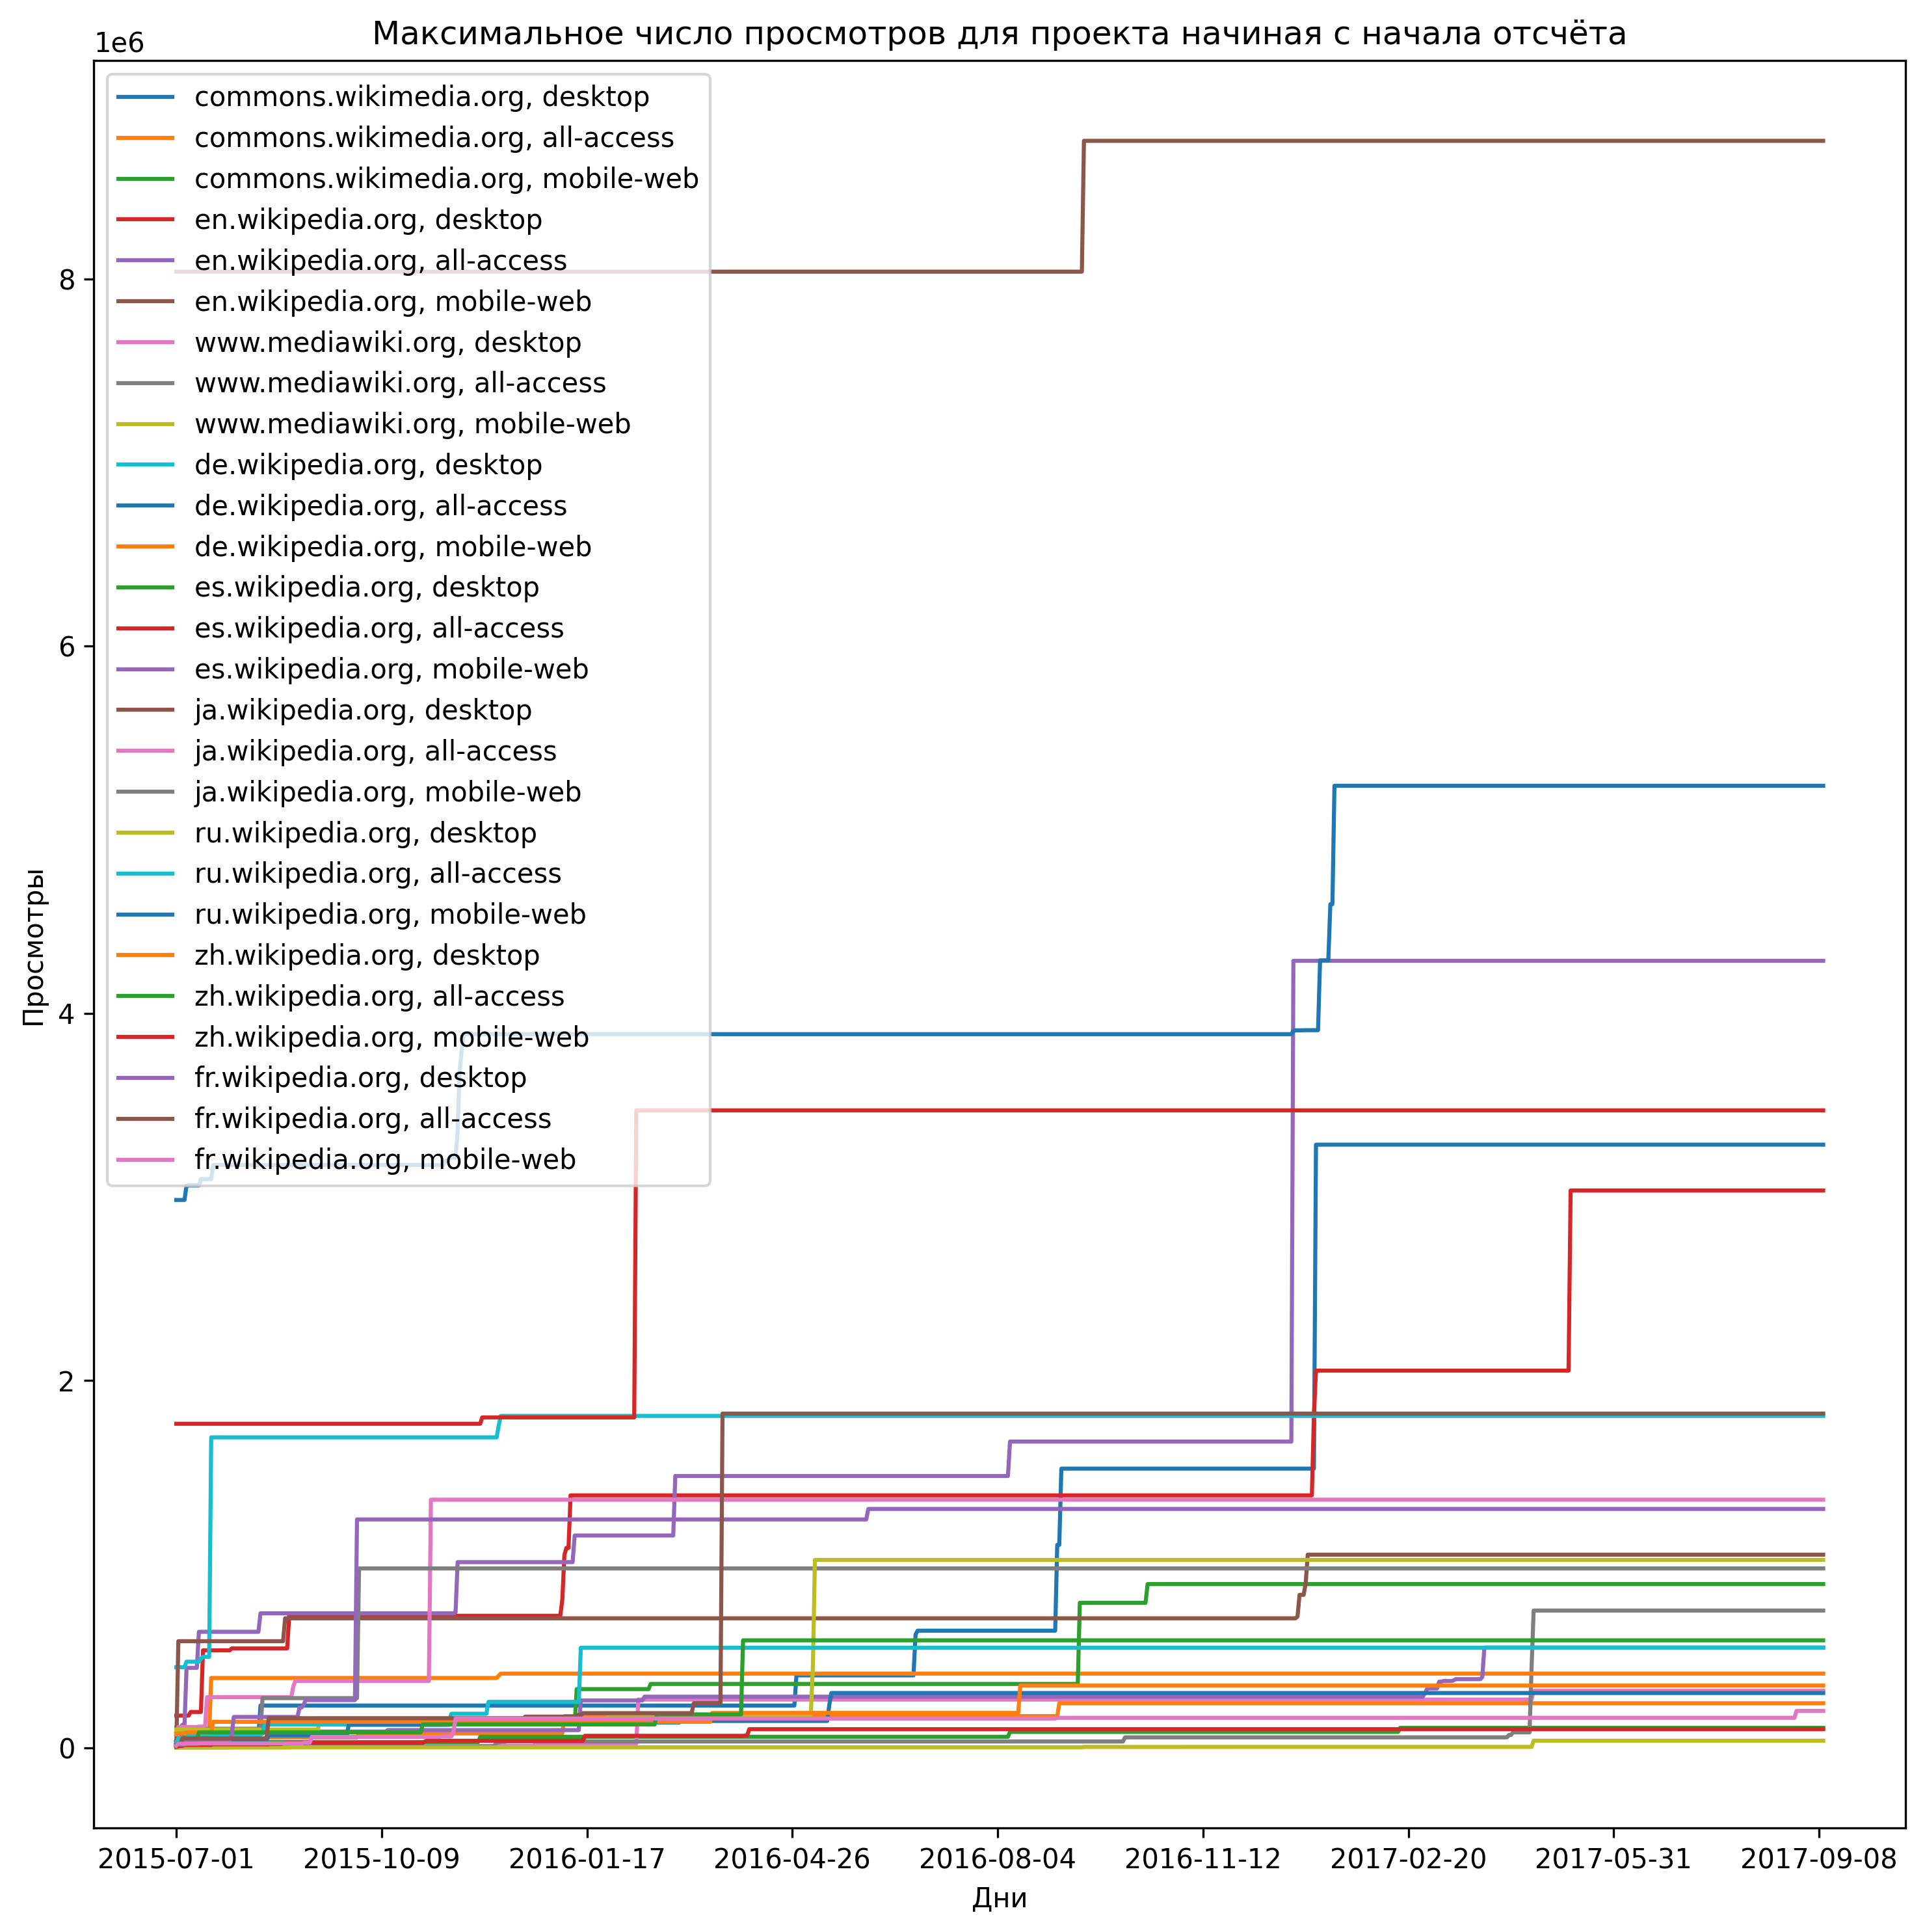

In [30]:
# YOUR CODE HERE

**Задание 08:** Рассмотрим задачу предсказания числа просмотров конкретной страницы на следующий день. Рассмотрим два простейших варианта предсказания:
* Среднее за $7$ предыдущих дней
* Лаг с шагом $1$ — значение за предыдущий день

Создайте две колонки, которые будут содержать указанные варианты предсказания числа просмотров.

*Замечание:* Если предсказание не определено, то используйте среднее число просмотров страницы.

*Подсказка:* Вам могут пригодиться функции `cast`, `coalesce`.

In [32]:
### YOUR CODE HERE:

# заполним NULL значения средними значения по странице

# YOUR CODE HERE

+--------------------+----------+-----+-----------------+-----------------+--------------+
|                Page|       Day|Views|       Mean Views| Mean Predicition|Lag Prediction|
+--------------------+----------+-----+-----------------+-----------------+--------------+
|Idioma_español_es...|2015-07-01| 99.0|             99.0|             NULL|          NULL|
|Idioma_español_es...|2015-07-02|116.0|            107.5|             99.0|          99.0|
|Idioma_español_es...|2015-07-03| 70.0|             95.0|            107.5|         116.0|
|Idioma_español_es...|2015-07-04| 63.0|             87.0|             95.0|          70.0|
|Idioma_español_es...|2015-07-05| 59.0|             81.4|             87.0|          63.0|
|Idioma_español_es...|2015-07-06| 79.0|             81.0|             81.4|          59.0|
|Idioma_español_es...|2015-07-07| 54.0|77.14285714285714|             81.0|          79.0|
|Idioma_español_es...|2015-07-08| 83.0|           77.875|77.14285714285714|          54.0|

**Задание 09:** Оценим пролучившиеся модели. Для этого посчитаем метрику качества **SMAPE**:

$$
\text{SMAPE} = \frac{200\%}{n} \sum\limits_{i=1}^{n} \frac{|y_{i} - \hat{y}_{i}|}{|y_{i}| + |\hat{y}_{i}|}
$$

Где $y_{i}$, $\hat{y}_{i}$ — истинный ответ (таргет) и предсказание модели соответственно.

Подроднее прочитать про [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) и [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) можно на Википедии, а также у [А.Г. Дьяконова](https://alexanderdyakonov.files.wordpress.com/2018/10/book_08_metrics_12_blog1.pdf).

Для удобства реализуем подсчёт метрики в виде отдельной функции.

In [33]:
def count_smape(
    df: pyspark.sql.dataframe.DataFrame, 
    target_col: str, prediction_col: str,
    groups: Optional[List[str]]=None
) -> pyspark.sql.dataframe.DataFrame:
    '''
     :param pyspark.sql.dataframe.DataFrame df: Датафрейм для которого считается SMAPE
     :param str target_col: Название колонки в которой находятся истинные значения целевой переменной
     :param str prediction_col: Название колонки в которой находятся предсказания
     :param Optional[List[str]] groups: Список колонок по которым нужно выполнить агрегацию
         значений метрики для отдельных объектов выборки. Если `groups is None` нужно вернуть 
         среднее по всей выборке
     :return pyspark.sql.dataframe.DataFrame: 
    '''
    ### YOUR CODE HERE:
    ...

In [34]:
# SHOW SMAPE FOR LAG PREDICTION
count_smape(unpivot_with_predictions_df, 'Views', 'Lag Prediction').show()
# SHOW SMAPE FOR MEAN PREDICTION
count_smape(unpivot_with_predictions_df, 'Views', 'Mean Predicition').show()

+-----------------+
|            SMAPE|
+-----------------+
|36.15641300869311|
+-----------------+



+-----------------+
|            SMAPE|
+-----------------+
|36.81668069828338|
+-----------------+



In [37]:
# SHOW LAG SMAPE TABLE

# ...

# SHOW MEAN SMAPE TABLE

# ...

+---------------------+------------------+
|Project              |SMAPE             |
+---------------------+------------------+
|commons.wikimedia.org|59.79294767374322 |
|en.wikipedia.org     |32.50215978543699 |
|www.mediawiki.org    |62.52239744379478 |
|de.wikipedia.org     |37.38616421690639 |
|es.wikipedia.org     |32.801239970715834|
|ja.wikipedia.org     |31.87041530591758 |
|ru.wikipedia.org     |27.20325427992023 |
|zh.wikipedia.org     |33.35558511229612 |
|fr.wikipedia.org     |36.202212892225624|
+---------------------+------------------+



+---------------------+------------------+
|Project              |SMAPE             |
+---------------------+------------------+
|commons.wikimedia.org|64.27181953387972 |
|en.wikipedia.org     |32.76743545837842 |
|www.mediawiki.org    |59.01607604900401 |
|de.wikipedia.org     |36.82937396374509 |
|es.wikipedia.org     |33.39273346297721 |
|ja.wikipedia.org     |33.8639685316344  |
|ru.wikipedia.org     |28.342200397409115|
|zh.wikipedia.org     |32.96678238123975 |
|fr.wikipedia.org     |35.65632818144051 |
+---------------------+------------------+



**Задание 10:** Определите, какая из двух моделей работает лучше. Одинаковый ли результат получается для разных Project? А для Agent/Access?

In [38]:
### YOUR CODE HERE:

# SHOW SMAPE LAG 
# SHOW SMAPE MEAN 


+----------+----------+------------------+
|Agent     |Access    |SMAPE             |
+----------+----------+------------------+
|all-agents|mobile-web|33.1425491773467  |
|spider    |all-access|54.90139175515493 |
|all-agents|all-access|29.580478875393712|
|all-agents|desktop   |27.79949232854075 |
+----------+----------+------------------+



+----------+----------+------------------+
|Agent     |Access    |SMAPE             |
+----------+----------+------------------+
|all-agents|mobile-web|37.002672392460404|
|spider    |all-access|49.7894382529735  |
|all-agents|all-access|31.130940748773693|
|all-agents|desktop   |29.904292417501754|
+----------+----------+------------------+



**Ответ:** Ваш ответ здесь.